#**Dispersión de Thomson en el Sol**

Cuando una onda electromagnética incide en un electrón, produce una vibración en dicho electrón que da lugar a una segunda onda con la misma frecuencia, y por tanto, con la misma energía, en otra dirección. Dicha onda, tendrá sin embargo una menor intensidad.

Deben cumplirse **dos condiciones** para que tenga lugar la dispersión de Thomson:

1.   La **longitud de coherencia** de la radiación es pequeña en comparación con la separación entre las partículas.
2.   La **energía de los fotones** es despreciable en comparación con la energía de la masa del resto de partículas.

*T.A. Howard, S.J. Tappin (Interplanetary Coronal Mass Ejections Observed in the Heliosphere: 1. Review of Theory, 27 May 2009)*

Sección eficaz para un electrón: **7.95E-30 m²sr-¹**

1.   List item
2.   List item




***Dispersión de Thomson en la corona solar***: podemos observar el fenómeno de la dispersión de Thomson en la corona del Sol, donde los fotones emitidos desde la fotosfera interaccionan con los electrones libres del plasma de la corona.
En particular, se puede utilizar la información que nos da este fenómeno para estudiar la masa de las eyecciones de masa coronal, EMCs (en inglés, *Coronal Mass Ejections, CMEs*).

##**1. Geometría y fenómeno de la dispersión de Thomson**

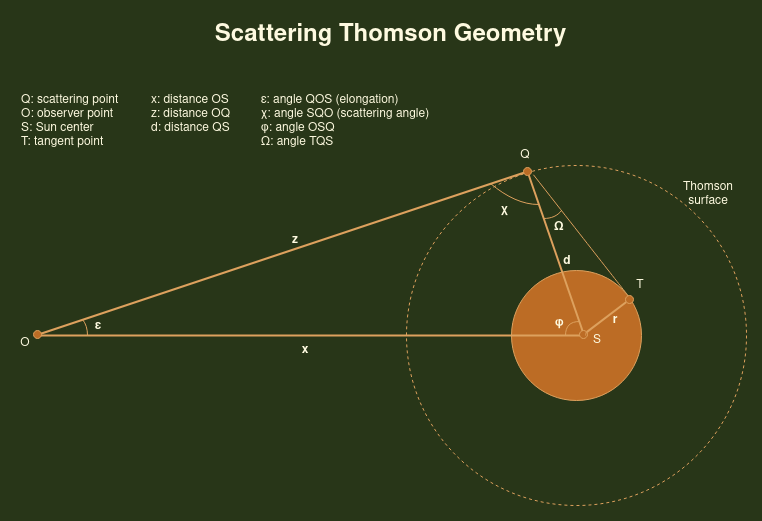

### 1.1. Definición de **clases**, **constantes** y **parámetros iniciales**

Importación de librerías y definición de constantes para la realización de los cálculos:

In [ ]:
from math import *
from matplotlib import pyplot
from enum import Enum
import numpy as np
import universal_constants as uc
from units import *
import thomson_scattering_params as tsp
import ne_models as ne
RSOL = RSOL_TO_METERS

####Constantes

In [ ]:
class ThomsonGeometry:

    def __init__(self, sun_center, target, radius):
      '''
      Description
      -----------
      Creates a ThomsonGeometry object, which stores and maintains the fundamental
      magnitudes of the Thomson scattering geometry.

      Parameters
      ----------
      sun_center: Center of the Sun (S) in coordinates of the Obsever Reference 
                  System.
      target: Scattering Point (Q) in coordinates of the Obsever Reference 
                  System.
      radius: stellar radius. 

      Returns
      ----------
      A ThomsonGeometry object.
      '''
      # Zero margin value for floating and double comparisons.
      self.__zero = 1E-6

      # Radius of the star.
      self.__radius = radius
      # Origin of the Observer Reference System.
      self.__observer = np.array([0, 0, 0])
      # Position of the Center of the Sun.
      self.__sun_center = sun_center

      # Distance OQ between the Observer and the Scattering Point (z).
      self.__OQ_dist = np.linalg.norm(target - self.__observer)
      # Distance OS between the Observer and the Center of the Sun (x).
      self.__OS_dist = np.linalg.norm(sun_center - self.__observer)
      # Distance SQ between the Center of the Sun and the Scattering Point (d).
      self.__SQ_dist = np.linalg.norm(target - sun_center)

      # Elongation between SQ and OQ distances.
      self.__elongation =  np.arcsin(self.__SQ_dist / self.__OQ_dist)

      # Unitary directional vector pointing from the Observer to the Scattering 
      # Point.
      v = target - self.__observer
      norm = np.linalg.norm(v)
      if (norm > (0 + self.__zero)) or (norm < (0 - self.__zero)):
        self.__direction = v / norm
      else:
        self.__direction = np.array([0, 0, 0])
      
    def __str__(self) -> str:
      return 'Radius = {}\nObserver = {}\nSun Center at {}\nOQ = {}\nOS = {}\nSQ = {}\nelongation = {}º\ndirection = {}'.format(self.__radius, 
                                                                                                                self.__observer,
                                                                                                                self.__sun_center,
                                                                                                                self.__OQ_dist,
                                                                                                                self.__OS_dist,
                                                                                                                self.__SQ_dist,
                                                                                                                degrees(self.__elongation),
                                                                                                                self.__direction)
      
    def __repr__(self) -> str:
      return '{self.__class__.__name__}({self.__radius, self.__observer, self.__sun_center, self.__OQ_dist, self.__OS_dist, self.__SQ_dist, self.__elongation, self.__direction})'.format(self=self)
      

    def get_target(self, s):
      """
      Description
      -----------
      Computes the target of Thomson scattering (a.k.a. real-time scattering 
      point) with the parameter s.

      Parameters
      -----------
      s: parameter of the segment.

      Returns
      -----------
      (x, y, z) as a target for Thomson scattering.
      """
      target = self.__observer + s * self.__direction
      return target

    def get_radius(self):
      """
      Description
      -----------
      Gets the radius of the star.

      Returns
      -----------
      Radius of the star.
      """
      return self.__radius

    def get_distance_OS(self):
      """
      Description
      -----------
      Gets the distance between the Observer (O) and the Center of the Sun (S).

      Returns
      -----------
      Distance OS.
      """
      return self.__OS_dist

    def get_distance_OQ(self):
      """
      Description
      -----------
      Gets the distance between the Observer (O) and the Scattering Point (Q).

      Returns
      -----------
      Distance OQ.
      """
      return self.__OQ_dist

    def get_distance_SQ(self):
      """
      Description
      -----------
      Gets the distance between the Center of the Sun (S) and the Scattering Point (Q).

      Returns
      -----------
      Distance SQ.
      """
      return self.__SQ_dist    

    def get_elongation(self):
      return self.__elongation
    
    # Primera parte: para un solo electrón.

    @staticmethod
    def faux_omega_d(d, r = 1):
      '''
      Devuelve un valor para el ángulo omega (T-Q-S) en radianes (rad) en función de
      la distancia, d, del centro de la estrella, S, al punto de dispersión, Q.

      En el caso de que se emplee el radio estelar como unidad, por defecto, r = 1.
      
      Función auxiliar de la geometría de la dispersión de Thomson.

      Parámetros
      ----------
      d: distancia entre el centro de la estrella, S, y el punto de dispersión, Q.
      r: radio de la estrella. 

      Devuelve
      ----------
      Valor del ángulo omega en radianes (rad).
      '''

      return asin(r / d)

    @staticmethod
    def faux_z_intensidad(x, d, chi):
      '''
      Devuelve el valor de la distancia, z, del observador, O, al punto de 
      dispersión, Q, en función del ángulo de dispersión (S-Q-O) y de la distancia, 
      d, del punto de dispersión (Q) al centro de la estrella (S).

      Función auxiliar de la geometría de la dispersión de Thomson.

      Parámetros
      ----------
      x: distancia del observador (O) al centro de la estrella (S).
      d: distancia del punto de dispersión (Q) al centro de la estrella (S).
      chi: ángulo de dispersión (S-Q-O) en radianes (rad).

      Devuelve
      ----------
      Valor de la distancia, z, del observador, O, al centro de la estrella, S.
      '''

      return d * cos(chi) + sqrt(pow(d, 2) * (pow(cos(chi), 2) - 1) + pow(x, 2))

    # Segunda parte: a través de la línea del observador.

    @staticmethod
    def faux_d(x, z, epsilon):
      '''
      Devuelve un valor para la distancia, d, entre el Sol, S, y el punto de
      dispersión, Q, en función de la distancia, z, desde el observador, O, y el
      punto de dispersión, Q, y del ángulo de la elongación, epsilon.

      Función auxiliar de la geometría de la dispersión de Thomson.

      Parámetros
      ----------
      x: distancia del observador (O) al centro de la estrella (S).
      z: distancia entre el observador, O, y el punto de dispersión, Q.
      epsilon: ángulo de la elongación (S-Q-O) en radianes (rad).

      Devuelve
      ----------
      Valor de la distancia, d.
      '''

      return pow(pow(x, 2) + pow(z, 2) - 2 * x * z * cos(epsilon), 0.5)

    @staticmethod
    def faux_omega(x, z, epsilon, r = 1):
      '''
      Devuelve un valor para el ángulo omega (T-Q-S) en radianes (rad) en función de
      la distancia, z, del observador, O, al punto de dispersión, Q, y del ángulo de
      la elongación, epsilon.

      En el caso de que se emplee el radio estelar como unidad, por defecto, r = 1.

      Función auxiliar de la geometría de la dispersión de Thomson.

      Parámetros
      ----------
      x: distancia del observador (O) al centro de la estrella (S).
      z: distancia entre el observador, O, y el punto de dispersión, Q.
      epsilon: ángulo de la elongación (S-Q-O) en radianes (rad).
      r: radio de la estrella.

      Devuelve
      ----------
      Valor del ángulo omega en radianes (rad).

      Véase
      ----------
      faux_d: función auxiliar que obtiene la distancia d en función de 
      la distancia z y el ángulo epsilon.
      faux_omega_d: función auxiliar que obtiene el ángulo omega en función de la
      distancia d.
      '''

      return ThomsonGeometry.faux_omega_d(ThomsonGeometry.faux_d(x, z, epsilon), r)

    @staticmethod
    def faux_z(x, epsilon, phi):
      '''
      Devuelve el valor de la distancia, z, del observador, O, al punto de 
      dispersión, Q, en función del ángulo de la elongación (Q-O-S), epsilon, y del
      ángulo phi (O-S-Q).

      Función auxiliar de la geometría de la dispersión de Thomson.

      Parámetros
      ----------
      x: distancia del observador (O) al centro de la estrella (S).
      epsilon: ángulo de la elongación (Q-O-S) en radianes (rad).
      phi: ángulo O-S-Q en radianes (rad).

      Devuelve
      ----------
      Valor de la distancia, z, del observador, O, al centro del Sol, S, en radios
      solares (Rsol).
      '''

      return (x * tan(phi)) / (sin(epsilon) + tan(phi) * cos(epsilon))

####**Ley de desplazamiento de Wien**

In [ ]:
def ley_wien(onda):
  return 2.8978E-3 / onda

####**Ley de Planck:** radiación de cuerpo negro

En función de la **frecuencia**, $\nu$:
$$I_\nu = \frac{2 h \nu^3}{c^2}\frac{1}{e^{\frac{h \nu}{k T}}-1}$$

En función de la **longitud de onda**, $\lambda$:
$$I_\lambda = \frac{2 h c^2}{\lambda^5}\frac{1}{e^{\frac{hc}{\lambda k T}} - 1}$$
Donde:


* $h = 6.62607015·10^{-34} J·s$ es la constante de Planck.  
* $\nu $ es la frecuencia de la longitud de onda.
* $k = 1.38·10^{-23}J·K^{-1}$ es la constante de Boltzmann.
* $c = 3·10^8m·s^{-1}$ es la velocidad de la luz.
* $T = 5778 K$ es la temperatura (en este caso del Sol).



In [ ]:
def radiacion_planck(T, onda, es_long_onda = True):
  '''
  Ley de radiación de Planck para el cuerpo negro. Contempla las dos 
  expresiones, en función de la longitud de onda o en función de la frecuencia
  de la onda.

  Parámetros
  -----------
  T: temperatura efectiva del cuerpo negro.
  onda: longitud de onda en metros.
  es_long_onda: True si el valor del parámetro 'onda' se corresponde con la
  longitud de onda, False si no, y, por tanto, se corresponde con la frecuencia
  de la onda.

  Devuelve
  -----------
  La intensidad de radiancia del cuerpo negro en unidades (SI)
  '''
  
  if (es_long_onda):
    # Ley de Planck en función de la longitud de onda.
    i0 = (2 * uc.h * uc.c**2) / (onda**5 * (exp((uc.h * uc.c) / (onda * uc.k * T)) - 1))
  else:
    # Ley de Planck en función de la frecuencia de la onda.
    i0 = (2 * uc.h * onda**3) / (uc.c**2 * (np.exp((uc.h * onda) / (uc.k * T)) - 1))

  return i0


####Función de limb-darkening

In [ ]:
def allen_clv(wave,theta,check = 0):

    """
    Allen's Astrophysical Quantities, Springer, 2000 
    get u(lambda) from Allen tables. I(theta)/I{(O)
    theta = angle between the Sun's radius vector and the line of sight. In rad.
    wave = wavelength in Angstroms
    forth parameter is u!!!!!
    """

    def coefs(wave):
        u = (- 8.9829751 + 0.0069093916*wave - 1.8144591e-6*wave**2 + 2.2540875e-10*wave**3 -
            1.3389747e-14*wave**4 + 3.0453572e-19*wave**5 )
        v = (+ 9.2891180 - 0.0062212632*wave + 1.5788029e-6*wave**2 - 1.9359644e-10*wave**3 + 
            1.1444469e-14*wave**4 - 2.5994940e-19*wave**5 )
        return u,v

    try:
        if check == 1:
            gamma = np.arange(0,90,1)*np.pi/180.
            u,v = coefs(wave) 
            I = 1 - (u+v) + (u+v)*np.cos(gamma)
            clv = 1 - u - v + u*np.cos(gamma)+v*np.cos(gamma)
            plt.plot(gamma,clv)
            plt.plot(gamma,I,'--')
    except:
        pass
    u,v = coefs(wave) 
    if check == 2:
        return u + v
    return 1 - u - v + u*np.cos(theta)+v*np.cos(theta),u,v,u + v

def coef_limb_darkening(onda, unidades = 1E+10):
  '''
  Adaptación de la función allen_clv al parámetro necesario para la dispersión
  de Thomson, el coeficiente de limb-darkening (u).

  Parámetros
  -------------
  onda: longitud de onda en metros (m).
  unidades: factor de conversión necesario para que la longitud de onda se
  transforme a Ángstroms. Por defecto asume que el parámetro onda
  se da en unidades SI y, por tanto, multiplica por el factor 1E+10 para obtener
  Ángstroms.

  Véase
  ----------
  allen_clv: función basada en las tablas de Allen (Astrophysical Quantities, 
  Springer 2000) de SPG (IAA - CSIC).

  Devuelve
  ----------
  El coeficiente de limb-darkening (u).
  '''
  onda = onda * unidades
  return allen_clv(onda, 1, 2)

####Parámetros iniciales

In [ ]:
def print_params_state(RSOL, SIGMAe, ONDA, T, I0, U, X, EPSILON):
  print("RSOL =", RSOL, "m")
  print("SIGMAe =", SIGMAe, "m²sr⁻¹") # sección eficaz de un electrón, e, (m²sr⁻¹)
  print("ONDA =", ONDA, "m") # Longitud de onda en estudio, en metros (5000A)
  print("T =", T, "K") # K
  print("I0 =", I0) # intensidad de la fuente (el Sol)
  print("U =", U) # coeficiente de limb - darkening.
  print("X =", X, "RSOL") # RSol, distancia entre la Tierra y el Sol (O-S).
  print("EPSILON =", EPSILON, "rad")

### 1.2. Funciones auxiliares ligadas a la geometría de la dispersión de Thomson

## **2. Dispersión de Thomson para un único electrón**

###2.1. Obtención de los **coeficientes de van de Hulst**

Coeficiente **A** de van de Hulst:

In [ ]:
def vanDeHulstA(omega):
  '''
  Coeficiente A de van de Hulst en función del ángulo omega.

  Parámetros
  -----------
  omega: ángulo T-Q-S en radianes (rad).

  Devuelve
  ---------
  Valor del coeficiente A de van de Hulst.
  '''

  return cos(omega) * pow(sin(omega), 2)

Coeficiente **B** de van de Hulst:

In [ ]:
def vanDeHulstB(omega):
  '''
  Coeficiente B de van de Hulst en función del ángulo omega.

  Parámetros
  -----------
  omega: ángulo T-Q-S en radianes (rad).

  Devuelve
  ---------
  Valor del coeficiente B de van de Hulst.
  '''

  return -1 / 8 * (1 - 3 * pow(sin(omega), 2) - (pow(cos(omega), 2) / sin(omega)
   * (1 + 3 * pow(sin(omega), 2)) * log((1 + sin(omega)) / cos(omega))))

Coeficiente **C** de van de Hulst

In [ ]:
def vanDeHulstC(omega):
  '''
  Coeficiente C de van de Hulst en función del ángulo omega.

  Parámetros
  -----------
  omega: ángulo T-Q-S en radianes (rad).

  Devuelve
  ---------
  Valor del coeficiente C de van de Hulst.
  '''

  return 4 / 3 - cos(omega) - pow(cos(omega), 3) / 3

Coeficiente **D** de van de Hulst:

In [ ]:
def vanDeHulstD(omega):
  '''
  Coeficiente D de van de Hulst en función del ángulo omega.

  Parámetros
  -----------
  omega: ángulo T-Q-S en radianes (rad).

  Devuelve
  ---------
  Valor del coeficiente D de van de Hulst.
  '''

  return 1 / 8 * (5 + pow(sin(omega), 2) - (pow(cos(omega), 2) / sin(omega)) * 
                  (5 - pow(sin(omega), 2)) * log((1 + sin(omega)) / cos(omega)))

In [ ]:
def vanDeHulst(omega, coeficiente):
  '''
  Dado un valor para el ángulo omega, y el nombre de uno de los coeficientes
  de van de Hulst, devuelve su valor. Acepta el nombre tanto en minúsculas como
  en mayúsculas.

  Parámetros
  -----------
  omega: ángulo S-Q-T en radianes (rad).
  coeficiente: nombre del coeficiente de van de Hulst pedido.

  Devuelve
  ---------
  Valor del coeficiente de van de Hulst pasado como atributo.
  '''

  coeficiente = coeficiente.upper()

  # Coeficientes de van de Hulst en función del ángulo omega (T-Q-S).
  valorCoeficiente = -1
  if coeficiente == 'A':
    # Coeficiente A.
    valorCoeficiente = vanDeHulstA(omega)
  elif coeficiente == 'B':
    # Coeficiente B.
    valorCoeficiente = vanDeHulstB(omega)
  elif coeficiente == 'C':
    # Coeficiente C.
    valorCoeficiente = vanDeHulstC(omega)
  elif coeficiente == 'D':
    # Coeficiente D.
    valorCoeficiente = vanDeHulstD(omega)
  else:
    # Notifica al usuario de que ha introducido un nombre no válido para los
    # coeficientes de van de Hulst.
    print("[vanDeHulstDistanciaSol_ERR]::Coeficiente no válido.")
  return valorCoeficiente

### 2.2. Obtención de las **intensidades**

Intensidad **polarizada** (**Ip**)

In [ ]:
def Ip(i0, sigma_e, z, omega, chi, u):
  '''
  Dada una intensidad inicial, I0, la sección eficaz del electrón, sigma_e, la 
  distancia, z, del observador, O, al punto de dispersión, Q, el ángulo omega 
  (T-Q-S), el ángulo chi (S-Q-O) y el coeficiente de limb-darkening, u, devuelve
  la intensidad polarizada.

  Parámetros
  -----------
  i0: intensidad inicial en [ver unidades].
  sigma_e: sección eficaz del electrón (m²sr-¹).
  z: distancia del observador, O, al punto de dispersión Q.
  omega: ángulo T-Q-S en radianes (rad).
  chi: ángulo de dispersión (S-Q-O) en radianes (rad).
  u: coeficiente de limb-darkening en [0, 1].

  Devuelve
  ---------
  Valor de la intensidad polarizada.
  '''
  return i0 * (pi * sigma_e) / (2 * pow(z, 2)) * pow(sin(chi), 2) * ((1 - u) 
  * vanDeHulst(omega, 'A') + u * vanDeHulst(omega, 'B'))

Intensidad **tangencial** (**It**)

In [ ]:
def It(i0, sigma_e, z, omega, u):
  '''
  Dada una intensidad inicial, I0, la sección eficaz del electrón, sigma_e, la 
  distancia, z, del observador, O, al punto de dispersión, Q, el ángulo 
  omega (T-Q-S) y el coeficiente de limb-darkening, u, devuelve la intensidad 
  tangencial.

  Parámetros
  -----------
  i0: intensidad inicial en [ver unidades].
  sigma_e: sección eficaz del electrón (m²sr-¹).
  z: distancia del observador, O, al punto de dispersión Q.
  omega: ángulo T-Q-S en radianes (rad).
  u: coeficiente de limb-darkening en [0, 1].

  Devuelve
  ---------
  Valor de la intensidad tangencial.
  '''

  return i0 * (pi * sigma_e) / (2 * pow(z, 2)) * ((1 - u) 
  * vanDeHulst(omega, 'C') + u * vanDeHulst(omega, 'D'))

Intensidad **radial** (**Ir**)

In [ ]:
def Ir(i0, sigma_e, z, omega, chi, u):
  '''
  Dada una intensidad inicial, i0, la sección eficaz del electrón, sigma_e, la 
  distancia, z, del observador, O, al punto de dispersión, Q, el ángulo omega 
  (T-Q-S), el ángulo chi (S-Q-O) y el coeficiente de limb-darkening, u, devuelve
  la intensidad radial.

  Parámetros
  -----------
  i0: intensidad inicial en [ver unidades].
  sigma_e: sección eficaz del electrón (m²sr-¹).
  z: distancia del observador, O, al punto de dispersión Q.
  omega: ángulo T-Q-S en radianes (rad).
  chi: ángulo de dispersión (S-Q-O) en radianes (rad).
  u: coeficiente de limb-darkening en [0, 1].

  Devuelve
  ---------
  Valor de la intensidad radial.
  '''
  return It(i0, sigma_e, z, omega, u) - Ip(i0, sigma_e, z, omega, chi, u)

Intensidad **total** (**Itotal**)

In [ ]:
def Itotal(i0, sigma_e, z, omega, chi, u):
  '''
  Dada una intensidad inicial, i0, la sección eficaz del electrón, sigma_e, la 
  distancia, z, del observador, O, al punto de dispersión, Q, el ángulo omega 
  (T-Q-S), el ángulo chi (S-Q-O) y el coeficiente de limb-darkening, u, devuelve
  la intensidad radial.

  En base a las intensidades tangencial y polarizada calcula la intensidad total
  dispersada.

  Parámetros
  -----------
  i0: intensidad inicial en [ver unidades].
  sigma_e: sección eficaz del electrón (m²sr-¹).
  z: distancia del observador, O, al punto de dispersión Q.
  omega: ángulo T-Q-S en radianes (rad).
  chi: ángulo de dispersión (S-Q-O) en radianes (rad).
  u: coeficiente de limb-darkening en [0, 1].

  Devuelve
  ---------
  Valor de la intensidad total.

  Véase
  ---------
  It: función de la intensidad tangencial.
  Ip: función de la intensidad polarizada.
'''
  return 2 * It(i0, sigma_e, z, omega, u) - Ip(i0, sigma_e, z, omega, chi, u)

## **3. Dispersión de Thomson a través de la línea de visión del observador**

###3.1. Estudio de la evolución de los parámetros necesarios para el cálculo de la dispersión de Thomson

Se definen cuatro listas:


1. ```epsilons```: contiene las distintas elongaciones para las cuales se va a observar la evolución de los parámetros en estudio (d, z, phi, etc.).
2. ```estilos```: contiene los diferentes formatos para las líneas de los gráficos para cada una de las elongaciones.
3. ```colores```: contiene los diferentes colores para las líneas de los gráficos para cada una de las elongaciones.
4. ```etiquetas```: contiene las diferentes etiquetas de las leyendas de los gráficos para cada una de las elongaciones.

La primera hace referencia a los experimentos a realizar sobre los parámetros necesarios para el cálculo de la dispersión de Thomson y la segunda, al formato de los gráficos en os que se representa esa experimentación.



In [ ]:
# Valores en radianes para las distintas elongaciones a experimentar.
epsilons = [  radians(5),     radians(20),      radians(30),        radians(45),        radians(60),        radians(90),      radians(135)] 

# Configuración para la visualización de los gráficos: estilos y colores de 
# líneas y etiquetas para la leyenda.
estilos = [       ':',              '-',              '--',              '-.',          (0, (1, 1)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 10))]
colores = [       'm',              'b',              'g',               'r',            'orange',         'brown',            'y']
etiquetas = ['Elongación 5º', "Elongación 20º", "Elongación 30º", "Elongación 45º", "Elongación 60º", "Elongación 90º", "Elongación 135º"]

### **3.2. Integración numérica**

####Funciones **necesarias para la integración** en la línea de visión

#####**Expresiones de la dispersión**
Simplificadas para la integración numérica.

In [ ]:
def Gt(omega, u, z = 1):
  '''
  Expresión de la dispersión de Thomson para la intensidad tangencial.

  Parámetros
  -----------
  omega: ángulo T-Q-S
  z: distancia del observador (O) al punto de dispersión (Q). Asigna z = 1 por
  defecto para la simplificación de cálculos en la integración numérica de la 
  dispersión a lo largo de la línea de visión.

  Devuelve
  -----------
  Valor de la dispersión tangencial.
  '''

  return (pi * tsp.SIGMA_E) / (2 * z**2) * ((1 - u) * vanDeHulst(omega, 'C') + u * vanDeHulst(omega, 'D'))

In [ ]:
def Gp(omega, u, z = 1):
  '''
  Expresión de la dispersión de Thomson para la intensidad polarizada.

  Parámetros
  -----------
  omega: ángulo T-Q-S
  z: distancia del observador (O) al punto de dispersión (Q). Asigna z = 1 por
  defecto para la simplificación de cálculos en la integración numérica de la 
  dispersión a lo largo de la línea de visión.

  Devuelve
  -----------
  Valor de la dispersión polarizada.
  '''

  return (pi * tsp.SIGMA_E) / (2 * z**2) * ((1 - u) * vanDeHulst(omega, 'A') + u * vanDeHulst(omega, 'B'))

In [ ]:
def Gr(omega, u, z = 1):
  '''
  Expresión de la dispersión de Thomson para la intensidad radial.

  Parámetros
  -----------
  omega: ángulo T-Q-S
  z: distancia del observador (O) al punto de dispersión (Q). Asigna z = 1 por
  defecto para la simplificación de cálculos en la integración numérica de la 
  dispersión a lo largo de la línea de visión.

  Devuelve
  -----------
  Valor de la dispersión radial.
  '''

  return Gt(omega, u, z) - Gp(omega, u, z)

In [ ]:
def Gtotal(omega, u, z = 1):
  '''
  Expresión de la dispersión de Thomson para la intensidad total.

  Parámetros
  -----------
  omega: ángulo T-Q-S
  z: distancia del observador (O) al punto de dispersión (Q). Asigna z = 1 por
  defecto para la simplificación de cálculos en la integración numérica de la 
  dispersión a lo largo de la línea de visión.

  Devuelve
  -----------
  Valor de la dispersión total.
  '''

  return 2 * Gt(omega, u, z) - Gp(omega, u, z)

#####**Funciones de integración numérica**
Respecto de z, en Rsol, y respecto del ángulo phi (O-S-Q).

In [ ]:
def f_Irec_z(x, epsilon, z, u, r = RSOL):
  '''
  Función de la intensidad recibida por la dispersión de Thomson en un punto 
  z_i de la línea de visión.

  Parámetros
  ------------
  x: distancia del observador (O) al centro de la estrella (S).
  epsilon: ángulo de la elongación, S-Q-O, en radianes (rad).
  z: distancia del observador (O) al punto de dispersión (Q).
  r: radio de la estrella. Asigna r = RSOL por defecto, para trabajar en 
  unidades SI. Si r = 1, se entiende que se trabaja en el radio de la estrella.

  Devuelve
  ------------
  El valor de la dispersión de Thomson recibida para un z_i dado.
  '''
        
  #return get_ne(ne_function) * Gtotal(faux_omega(x, z, epsilon, r), u)
  return ne.crammer_model(ThomsonGeometry.faux_d(x, z, epsilon) / r) * Gtotal(ThomsonGeometry.faux_omega(x, z, epsilon, r), u)
  
def Irec_z(x, epsilon, ini_z, fin_z, incr_z, u, r = RSOL):
  '''
  Integración numérica de la dispersión de Thomson recibida a lo largo de toda
  la línea de visión (integración sobre la variable z).

  Parámetros
  ------------
  x: distancia del observador (O) al centro de la estrella (S).
  epsilon: ángulo de la elongación, S-Q-O, en radianes (rad).
  z: distancia del observador (O) al punto de dispersión (Q). Límite superior de
  la integración.
  incr_z: incremento de z para el cálculo de la integral numérica.
  r: radio de la estrella. Asigna r = RSOL por defecto, para trabajar en 
  unidades SI. Si r = 1, se entiende que se trabaja en el radio de la estrella.

  Devuelve
  ------------
  El valor de la dispersión de Thomson recibida para un z_i dado.
  '''

  pasos_z = np.arange(ini_z, fin_z + incr_z, incr_z)
  valorIrec = 0
  for i in pasos_z:
    valorIrec += abs(f_Irec_z(x, epsilon, i + 1, u, r) - f_Irec_z(x, epsilon, i, u, r)) * incr_z
  return valorIrec

def f_Irec_PHI(x, epsilon, phi, u, r = RSOL):
  '''
  Función de la intensidad recibida por la dispersión de Thomson para un ángulo
  dado phi_i.

  Parámetros
  ------------
  x: distancia del observador (O) al centro de la estrella (S).
  epsilon: ángulo de la elongación, S-Q-O, en radianes (rad).
  phi: ángulo O-S-Q, en radianes (rad).
  r: radio de la estrella. Asigna r = RSOL por defecto, para trabajar en 
  unidades SI. Si r = 1, se entiende que se trabaja en el radio de la estrella.

  Devuelve
  ------------
  El valor de la dispersión de Thomson recibida para un ángulo phi_i dado.
  '''
  valor_contribucion_fIrec = 0
  return valor_contribucion_fIrec 

def Irec_PHI(x, epsilon, phi, incr_phi, u, r = RSOL):
  '''
  Integración numérica de la dispersión de Thomson recibida a lo largo de toda
  la línea de visión (integración sobre la variable phi).

  Parámetros
  ------------
  x: distancia del observador (O) al centro de la estrella (S).
  epsilon: ángulo de la elongación, S-Q-O, en radianes (rad).
  phi: ángulo O-S-Q, en radianes (rad). Límite superior de la integración.
  phi_z: incremento de phi para el cálculo de la integral numérica.
  r: radio de la estrella. Asigna r = RSOL por defecto, para trabajar en 
  unidades SI. Si r = 1, se entiende que se trabaja en el radio de la estrella.

  Devuelve
  ------------
  El valor de la dispersión de Thomson recibida para un z_i dado.
  '''

  # Integración numérica de la función intensidad recibida a lo largo de la línea
  # de visión, mediante incrementos de z.
  pasos_phi = np.arange(0, phi + incr_phi, incr_phi)
  valorIrec = 0
  for i in pasos_phi:
      valorIrec += abs(f_Irec_PHI(x, epsilon, i + 1, u, r) - f_Irec_PHI(x, epsilon, i, u, r)) * incr_phi
  return valorIrec

# 4. Espectro de la K - Corona

Cálculo de la intensidad final dispersada:

In [ ]:
def get_scattered_light(wave, temperature, x, epsilon, ini_z, fin_z, incr_z, r = RSOL):
  """  
  Computation of the scattered light by the Thomson Scattering of the K-Corona.

  Parameters
  ------------
  wave: float
    Wavelength of the solar spectrum, assumed to be in meters (m).
  temperature: float
    Temperature of the Sun, assumed to be in Kelvins (K).

  Returns
  ------------
  scattered_light: float
    Scattered light for a given wavelength and temperature, in W·m^-3.
  """
  u = coef_limb_darkening(wave)
  I0 = radiacion_planck(temperature, wave)
  scattering = Irec_z(x, epsilon, ini_z, fin_z, incr_z, u, r)
  
  scattered_light = I0 * scattering

  return scattered_light
